### 用taxi gps数据计算每一辆出租车在一天内的收入
本文件为数据预处理,根据出租车原始GPS数据得到相应可处理数据

分析：输入为TAXIGPS数据。输出的形式,应该是：每条订单,收入。
为了后续的分析,在输出的基础上,需要再增加：
订单号,收入,车牌号,订单开始时间,订单结束时间,订单上车坐标,订单下车坐标,行驶里程

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

# 读取数据,为data-sample文件夹下的TaxiData-Sample
data2 = pd.read_csv(r'data-sample/TaxiData-Sample',header = None)
# 给数据命名列
data2.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']

data2.head(5)

,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed
0,22271,22:54:04,114.167000,22.718399,0,0
1,22271,18:26:26,114.190598,22.647800,0,4
2,22271,18:35:18,114.201401,22.649700,0,0
3,22271,16:02:46,114.233498,22.725901,0,24
4,22271,21:41:17,114.233597,22.720900,0,19


对数据进行处理，从而能够计算里程与候车时间

In [5]:
data2=data2.sort_values(by=['VehicleNum','Stime'])

# 去除重复数据,数据清洗得到表1,字段与原始数据一致，openstatus为1表示载客，为0表示空车
data2 = data2[-((data2['OpenStatus'].shift(1)== data2['OpenStatus'].shift(-1))&\
      (data2['OpenStatus'].shift(1)!= data2['OpenStatus'])&\
      (data2['VehicleNum'].shift(1)==data2['VehicleNum'].shift(-1))&\
      (data2['VehicleNum']==data2['VehicleNum'].shift(1)))]

# 将时间字符串转换为pd的时间格式,后面可以轻松的做加减
data2['Stime'] = pd.to_datetime(data2['Stime'])

# 订单号生成
data2['OpenStatus1'] = data2['OpenStatus'].shift()
data2['VehicleNum1'] = data2['VehicleNum'].shift()

data2['Lng1'] = data2['Lng'].shift()
data2['Lat1'] = data2['Lat'].shift()
data2['Stime1'] = data2['Stime'].shift()

data2['StatusChange'] = data2['OpenStatus1']-data2['OpenStatus']

# 筛选出车辆状态变化的数据
data2 = data2[data2['OpenStatus1']==1]
data2['orderid'] = data2['StatusChange'].cumsum()
# print(data2.head(30))

# 对数据进行处理,得到表2，字段为：订单号,轨迹点经纬度,轨迹点的时间（订单号需要自己定义）,速度（用来计算候时时长）
table2 = data2[['orderid','Lng','Lat','Stime','Speed']]

table2.head(5)

,orderid,Lng,Lat,Stime,Speed
1548741,0.0,114.111130,22.576750,2023-05-18 00:00:52,13
1550370,1.0,114.111130,22.576750,2023-05-18 00:01:04,0
1549616,1.0,114.080551,22.554251,2023-05-18 00:08:17,0
1549617,1.0,114.080551,22.554251,2023-05-18 00:08:37,0
1547008,1.0,114.080551,22.554251,2023-05-18 00:08:57,0


计算里程与候车时间需要定义计算路径长度函数

In [6]:
# 定义计算路径长度函数

from math import pi
import numpy as np
def getdistance(lon1, lat1, lon2, lat2): # 经度1,纬度1,经度2,纬度2 （十进制度数）输入为DataFrame的列
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(lambda r:r*pi/180, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(a**0.5) 
    r = 6371 # 地球平均半径,单位为公里
    return c * r * 1000

通过上面的函数计算得到订单里程距离（即每单的路径长度）
再集计得到出租车等待时间
连接表2与表3成为表3，字段为：订单号,订单的里程,候时时长（已计算每个订单的里程和候时时长）

In [7]:
# 生成订单的里程
table3 = table2.copy()
table3['Lng1'] = table3['Lng'].shift(-1)
table3['Lat1'] = table3['Lat'].shift(-1)
table3['orderid1'] = table3['orderid'].shift(-1)
table3['Stime1'] = table3['Stime'].shift(-1)

table3 = table3[(table3['orderid1'] == table3['orderid'])]
# 计算每个点与下一个点的距离
lon1 = table3['Lng']
lat1 = table3['Lat']
lon2 = table3['Lng1']
lat2 = table3['Lat1']
table3['distance'] = getdistance(lon1, lat1, lon2, lat2)

# 计算每个点与下一个点的时间差
table3['interval'] = (table3['Stime1']-table3['Stime']).apply(lambda r:r.seconds)

# 集计得到出租车路径长度
orderlenth = table3[['orderid','distance']].groupby('orderid').sum().reset_index()
# 集计得到出租车等待时间
waittime = table3[table3['distance']==0][['orderid','interval']].groupby('orderid').sum()

# 连接表2与表3成为表3，字段为：订单号,订单的里程,候时时长（已计算每个订单的里程和候时时长）
table3 = pd.merge(orderlenth,waittime,on = 'orderid',how='left')

table3.head(5)

,orderid,distance,interval
0,1.0,6785.602632,180.0
1,2.0,15698.063306,309.0
2,3.0,12508.941904,140.0
3,4.0,15144.760499,100.0
4,5.0,15458.541238,60.0


进行表4的处理，从表3中获取到出行的时间，从而推测计算单价

In [8]:
# 表4的字段：订单号,车牌号,订单开始时间,订单结束时间,订单上车坐标,订单下车坐标，整理出每个订单的其他信息
# 将每一个出行的起点与终点提取出来
o = data2.iloc[:1].append(data2[data2['StatusChange']==1])
d = data2[(data2['StatusChange']==1).shift(-1).fillna(False)]
table4 = o.append(d).sort_values(by = ['orderid','Stime'])[['orderid','VehicleNum','Stime','Lng','Lat']]

# 加一列isd,如果该行为起点,则isd=0,如果该行为终点,则isd=1
table4['isd'] = [i%2 for i in range(len(table4))]

# 把O与D的信息放在同一行
table4['Etime'] = table4['Stime'].shift(-1)
table4['ELng'] = table4['Lng'].shift(-1)
table4['ELat'] = table4['Lat'].shift(-1)
table4 = table4[(table4['isd']==0)&(-table4['Etime'].isnull())]

# 连接表3与表4成为表5，连接两个表,再计算订单收入
table5 = pd.merge(table4,table3,on = 'orderid',how = 'left')

# 根据深圳出租车规则,每天的23时至次日凌晨6时为夜间
table5['isnight'] = (table5['Stime'].apply(lambda r:r.hour)<6)|(table5['Stime'].apply(lambda r:r.hour)>=23)

table4.head(5)

C:\Users\14684\AppData\Local\Temp\ipykernel_12816\1910451827.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  o = data2.iloc[:1].append(data2[data2['StatusChange']==1])
C:\Users\14684\AppData\Local\Temp\ipykernel_12816\1910451827.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table4 = o.append(d).sort_values(by = ['orderid','Stime'])[['orderid','VehicleNum','Stime','Lng','Lat']]


,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat
1548741,0.0,22334,2023-05-18 00:00:52,114.111130,22.576750,0,2023-05-18 00:00:52,114.111130,22.576750
1550370,1.0,22334,2023-05-18 00:01:04,114.111130,22.576750,0,2023-05-18 00:17:58,114.084915,22.540850
1550727,2.0,22334,2023-05-18 00:18:16,114.084915,22.540850,0,2023-05-18 00:44:47,114.056236,22.633383
1550647,3.0,22334,2023-05-18 00:44:52,114.056236,22.633383,0,2023-05-18 02:46:52,114.093498,22.554382
1548364,4.0,22334,2023-05-18 02:47:04,114.093536,22.554382,0,2023-05-18 04:13:57,114.052299,22.604366


计价规则：  
>1 起步价：首2公里11.00元;  
2 里程价：超过2公里部分,每公里2.40元;  
3 返空费：每天的23时至次日凌晨6时,超过25公里部分,每公里按上述里程价的30%加收返空费：  
4 夜间附加费：夜间起步价16元,每天的23时至次日凌晨6时,按上述起步价和里程价的20%加收夜间附加费;  
5 候时费：每分钟0.80元;  
6 大件行李费：体积超过0.2立方米、重量超过20公斤的大件行李，每件0.50元。无法分析这项数据，略去。

In [9]:
table5['起步价'] = table5['isnight']*(16-11)+11
table5['里程价'] = ((table5['distance']-2000)>0)*(table5['distance']-2000)*2.4/1000
table5['返空费'] = table5['isnight']*((table5['distance']-25000)>0)*((table5['distance']-25000)*2.4*0.3/1000)
table5['夜间附加费'] = table5['isnight']*((table5['distance']-2000)>0)*(table5['distance']-2000)*2.4*0.2/1000
table5['候时费'] = table5['interval']/60*0.8
table5['price'] = table5['起步价'] + table5['里程价'] + table5['返空费'] + table5['夜间附加费'] + table5['候时费']

# 筛选掉没有计算出来价格的数据
table5 = table5[-table5['price'].isnull()]

# 保存成csv文件
table5.to_csv(r'data-sample/taxi-price-new.csv',index = None)
table5.head(10)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight,起步价,里程价,返空费,夜间附加费,候时费,price
1,1.0,22334,2023-05-18 00:01:04,114.111130,22.576750,0,2023-05-18 00:17:58,114.084915,22.540850,6785.602632,180.0,True,16,11.485446,-0.0,2.297089,2.400000,32.182536
2,2.0,22334,2023-05-18 00:18:16,114.084915,22.540850,0,2023-05-18 00:44:47,114.056236,22.633383,15698.063306,309.0,True,16,32.875352,-0.0,6.575070,4.120000,59.570422
3,3.0,22334,2023-05-18 00:44:52,114.056236,22.633383,0,2023-05-18 02:46:52,114.093498,22.554382,12508.941904,140.0,True,16,25.221461,-0.0,5.044292,1.866667,48.132419
4,4.0,22334,2023-05-18 02:47:04,114.093536,22.554382,0,2023-05-18 04:13:57,114.052299,22.604366,15144.760499,100.0,True,16,31.547425,-0.0,6.309485,1.333333,55.190244
5,5.0,22334,2023-05-18 04:23:07,114.052216,22.602118,0,2023-05-18 06:41:19,114.067886,22.521299,15458.541238,60.0,True,16,32.300499,-0.0,6.460100,0.800000,55.560599
6,6.0,22334,2023-05-18 06:41:20,114.067886,22.521299,0,2023-05-18 06:55:02,114.062798,22.517616,3797.074876,80.0,False,11,4.312980,-0.0,0.000000,1.066667,16.379646
7,7.0,22334,2023-05-18 06:55:12,114.062798,22.517616,0,2023-05-18 07:10:28,114.080414,22.558634,7497.547127,40.0,False,11,13.194113,-0.0,0.000000,0.533333,24.727446
8,8.0,22334,2023-05-18 07:10:38,114.080414,22.558634,0,2023-05-18 07:32:04,114.066635,22.541267,4287.367646,60.0,False,11,5.489682,-0.0,0.000000,0.800000,17.289682
9,9.0,22334,2023-05-18 07:32:06,114.066635,22.541267,0,2023-05-18 08:09:17,114.067970,22.522182,5056.517539,300.0,False,11,7.335642,-0.0,0.000000,4.000000,22.335642
10,10.0,22334,2023-05-18 08:09:23,114.067665,22.522232,0,2023-05-18 08:30:27,114.053780,22.535433,2732.022522,200.0,False,11,1.756854,-0.0,0.000000,2.666667,15.423521


##### #############基本绘图分析，可视化查看如下##################

### 一、使用python的matplotlib包和seaborn包对出租车GPS数据绘制数据统计图表

计时耗时： 0.4281010627746582 s


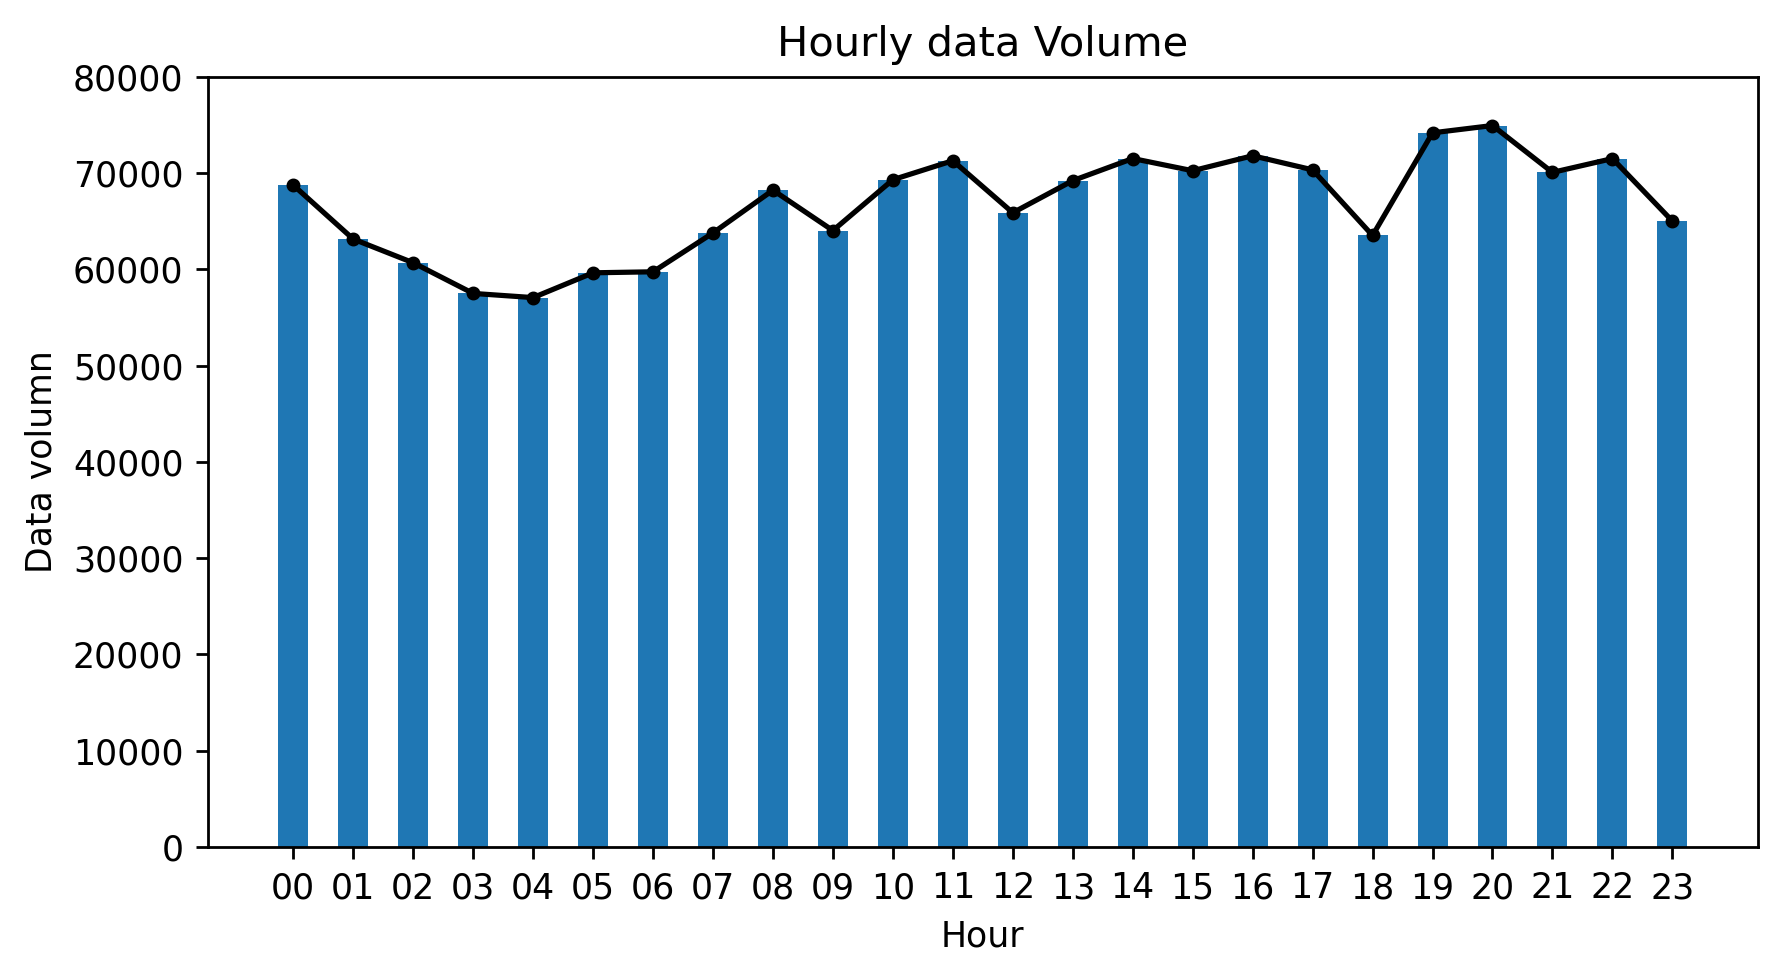

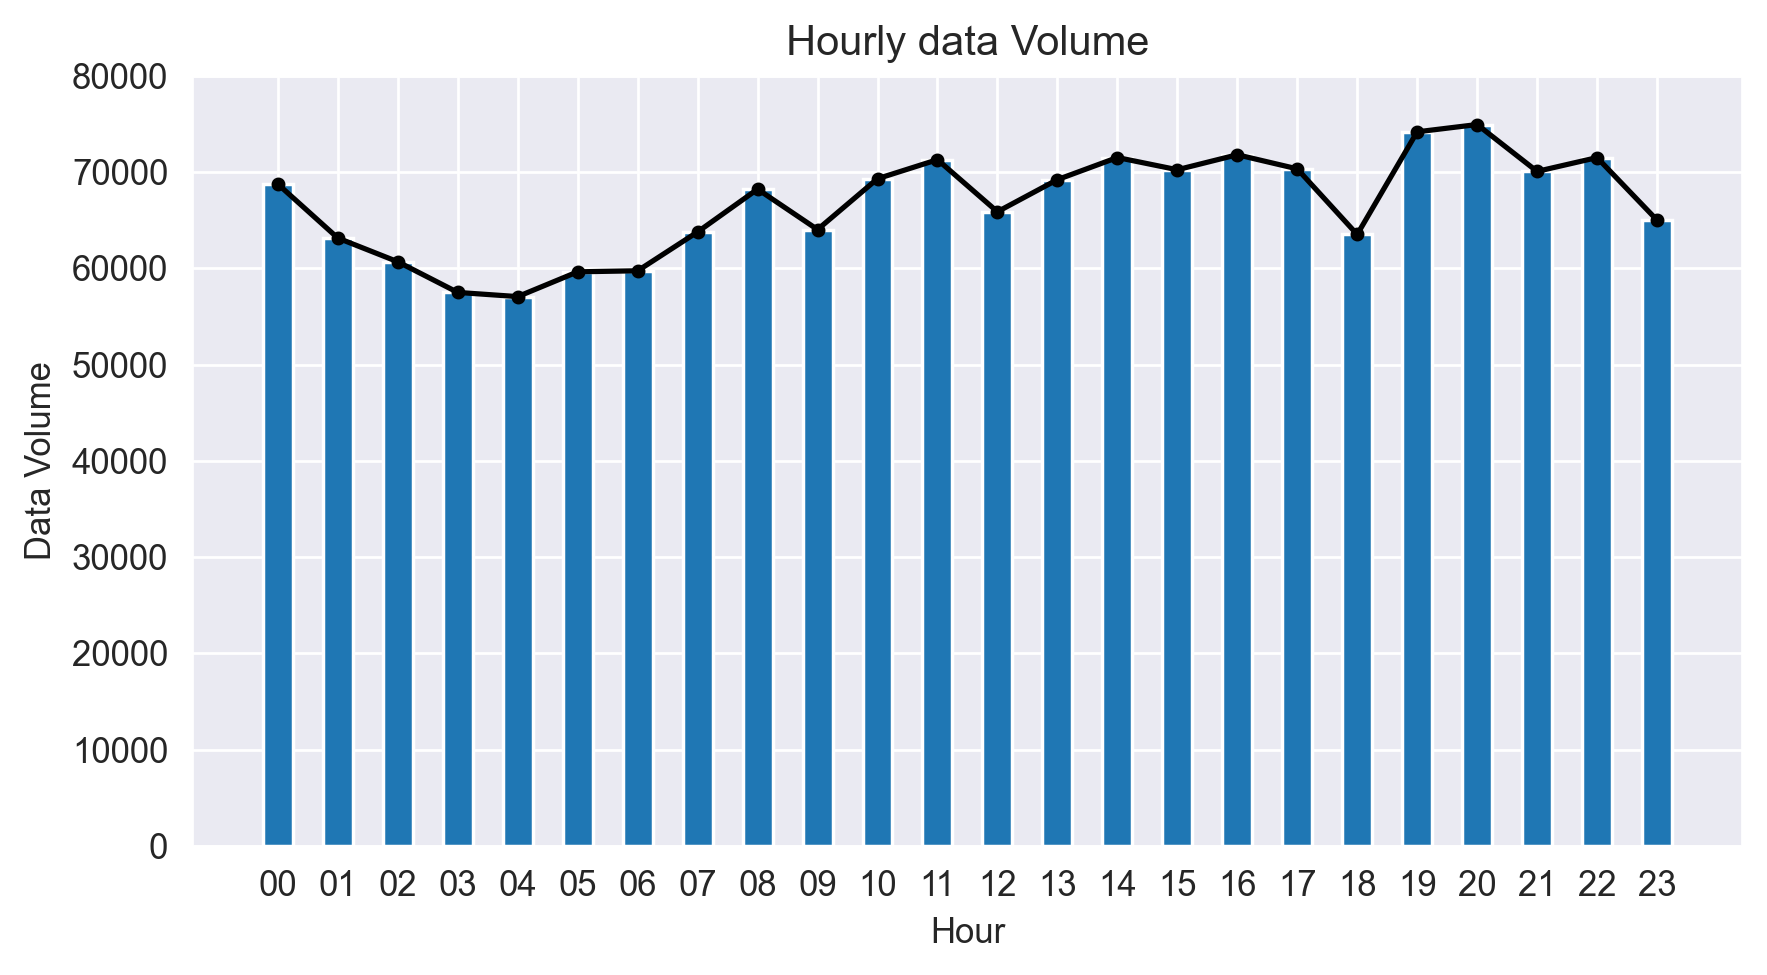

计时耗时 1.2372708320617676 s


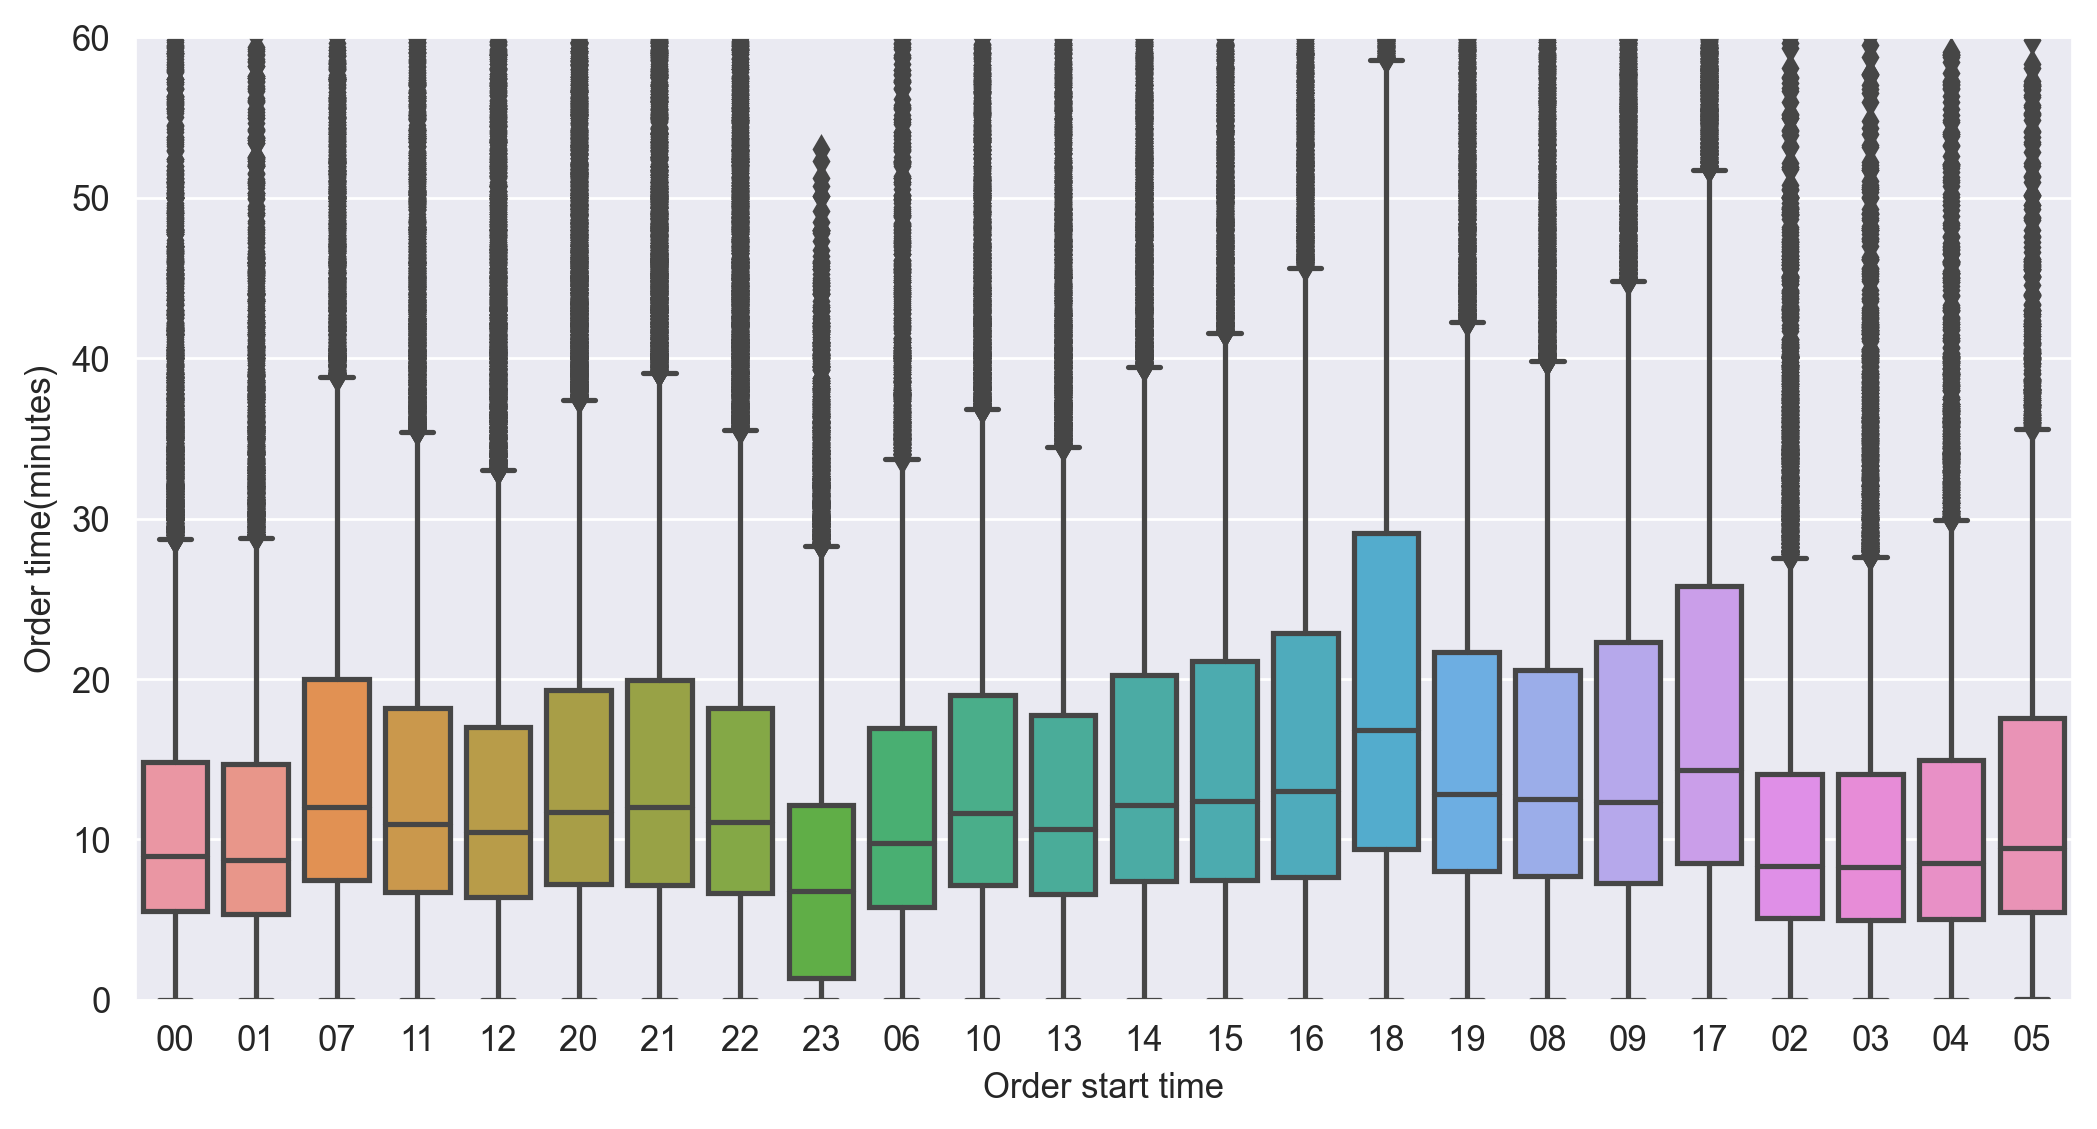

In [14]:
# 根据出租车GPS数据和OD数据，绘制出租车GPS数据的统计图表
data = pd.read_csv(r"data-sample/TaxiData-Sample", header=None)
data.columns = ["VehicleNum", "Stime", "Lng", "Lat", "OpenStatus", "Speed"]

# 读取OD数据
TaxiOD = pd.read_csv(r"data-sample/TaxiOD.csv")
TaxiOD.columns = ["VehicleNum", "Stime", "SLng", "SLat", "ELng", "ELat", "Etime"]

# 每小时GPS数据量绘图

# 计时：把时间当成字符串，遍历取字符串前两位
timeflag = time.time()
data["Hour"] = data["Stime"].apply(lambda r: r[:2])
print("计时耗时：", time.time() - timeflag, "s")
timeflag = time.time()

# 对每一列都计数，所以取其中一列出来，例如我这里取了['VehicleNum']
hourcount = (
    data.groupby(data["Stime"].apply(lambda r: r[:2]))["VehicleNum"]
    .count()
    .reset_index()
)

# 用matplotlib包来绘制每小时GPS数据量的图表
fig = plt.figure(1,(8,4),dpi = 250)    
ax = plt.subplot(111)
plt.sca(ax)

#折线图调整颜色加上数据点
plt.plot(hourcount['Stime'],hourcount['VehicleNum'],'k-',hourcount['Stime'],hourcount['VehicleNum'],'k.')
#加上条形图
plt.bar(hourcount['Stime'],hourcount['VehicleNum'],width =0.5)
plt.title('Hourly data Volume')

#把y轴起点固定在0
plt.ylim(0,80000)
plt.ylabel('Data volumn')
plt.xlabel('Hour')
plt.show()

# 保存到文件夹./images中
fig.savefig('./images/fig1-HourlydataVolume.png',dpi = 250)

# 加上seaborn的主题
sns.set_style("darkgrid", {"xtick.major.size": 10, "ytick.major.size": 10})
fig = plt.figure(1, (8, 4), dpi=250)
ax = plt.subplot(111)
plt.sca(ax)

# 折线图调整颜色加上数据点
plt.plot(
    hourcount["Stime"],
    hourcount["VehicleNum"],
    "k-",
    hourcount["Stime"],
    hourcount["VehicleNum"],
    "k.",
)
plt.bar(hourcount["Stime"], hourcount["VehicleNum"], width=0.5)
plt.title("Hourly data Volume")

# 把y轴起点固定在0
plt.ylim(0, 80000)
plt.ylabel("Data Volume")
plt.xlabel("Hour")
plt.show()
fig.savefig('./images/fig2-HourlydataVolume.png',dpi = 250)

# 对TaxiOD数据绘制OD数据量的图表，绘制订单持续时间分布图
TaxiOD = TaxiOD[-TaxiOD["Etime"].isnull()]
timeflag = time.time()

# 计算订单持续时间；可直接计算，也可转换为时间格式，相减后提取秒（非常慢），这里略去
TaxiOD["order_time"] = (
    TaxiOD["Etime"].str.slice(0, 2).astype("int") * 3600
    + TaxiOD["Etime"].str.slice(3, 5).astype("int") * 60
    + TaxiOD["Etime"].str.slice(6, 8).astype("int")
    - TaxiOD["Stime"].str.slice(0, 2).astype("int") * 3600
    - TaxiOD["Stime"].str.slice(3, 5).astype("int") * 60
    - TaxiOD["Stime"].str.slice(6, 8).astype("int")
)

# 计算耗时
print("计时耗时", time.time() - timeflag, "s")
timeflag = time.time()
TaxiOD['Hour'] = TaxiOD['Stime'].str.slice(0,2)

# 用seaborn包绘制以每小时分组的订单时间分布
fig = plt.figure(1,(10,5),dpi = 250)    
ax = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Hour", y=TaxiOD["order_time"]/60, data=TaxiOD,ax = ax)

plt.ylabel('Order time(minutes)')
plt.xlabel('Order start time')
plt.ylim(0,60)
plt.show()
fig.savefig('./images/fig3-ordertime.png')

### 二、使用python的geopandas包创建栅格，对出租车OD数据进行栅格对应，并绘制专题图
初始数据为深圳行政区划的GIS文件和出租车OD数据

In [15]:
# 导入必要的包
import pandas as pd
import numpy as np

# 绘制图用的包
import matplotlib as mpl
import matplotlib.pyplot as plt

# geopandas包和shapely包
import geopandas
from shapely.geometry import Point, Polygon, shape

# 读取shapefile文件
shp = r"shapefile/sz.shp"
sz = geopandas.GeoDataFrame.from_file(shp, encoding="utf-8")

# 栅格化代码：批量算出来一批经纬度的栅格编号
import math

d:\Anaconda3\envs\paddle_env\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


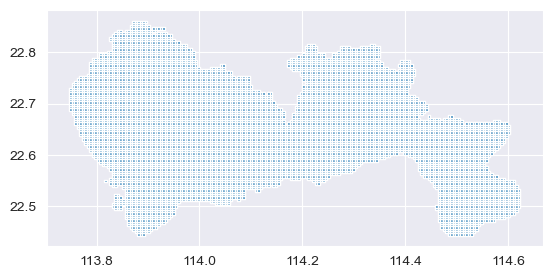

In [16]:
# 定义一个测试栅格划的经纬度
testlon = 114
testlat = 22.5

# 划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2)
lonStart = min(lon1, lon2)

# 定义栅格大小(单位m)
accuracy = 500

# 计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = (
    accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360))
)
deltaLat = accuracy * 360 / (2 * math.pi * 6371004)

# 计算栅格的经纬度编号，此处LONCOL、LATCOL的计算，我希望起点在第一个格子的中心，因此减去半个栅格
LONCOL = divmod(float(testlon) - (lonStart - deltaLon / 2), deltaLon)[0]
LATCOL = divmod(float(testlat) - (latStart - deltaLat / 2), deltaLat)[0]

# 计算栅格的中心点经纬度
HBLON = LONCOL * deltaLon + (lonStart - deltaLon / 2)  # 格子编号*格子宽+起始横坐标-半个格子宽=格子中心横坐标
HBLAT = LATCOL * deltaLat + (latStart - deltaLat / 2)

# 把算好的东西print出来看看
LONCOL, LATCOL, HBLON, HBLAT, deltaLon, deltaLat

# 生成这些栅格的geopandas数据
Polygon(
    [
        (HBLON + deltaLon / 2, HBLAT - deltaLat / 2),
        (HBLON + deltaLon / 2, HBLAT + deltaLat / 2),
        (HBLON - deltaLon / 2, HBLAT + deltaLat / 2),
        (HBLON - deltaLon / 2, HBLAT - deltaLat / 2),
    ]
)

# 定义空的geopandas表
data = geopandas.GeoDataFrame()

# 定义空的list，后面循环一次就往里面加东西
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

# 计算总共要生成多少个栅格
# lon方向是lonsnum个栅格
lonsnum = int((lon2 - lon1) / deltaLon) + 1
# lat方向是latsnum个栅格
latsnum = int((lat2 - lat1) / deltaLat) + 1

# 循环生成栅格
for i in range(lonsnum):
    for j in range(latsnum):
        HBLON = i * deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j * deltaLat + (latStart - deltaLat / 2)
        # 把生成的数据都加入到前面定义的空list里面
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)

        # 生成栅格的Polygon形状
        # 这里我们用周围的栅格推算三个顶点的位置，否则生成的栅格因为小数点取值的问题会出现小缝，无法完美覆盖
        HBLON_1 = (i + 1) * deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j + 1) * deltaLat + (latStart - deltaLat / 2)
        geometry.append(
            Polygon(
                [
                    (HBLON - deltaLon / 2, HBLAT - deltaLat / 2),
                    (HBLON_1 - deltaLon / 2, HBLAT - deltaLat / 2),
                    (HBLON_1 - deltaLon / 2, HBLAT_1 - deltaLat / 2),
                    (HBLON - deltaLon / 2, HBLAT_1 - deltaLat / 2),
                ]
            )
        )

# 为geopandas文件的每一列赋值为刚刚的list
data["LONCOL"] = LONCOL
data["LATCOL"] = LATCOL
data["HBLON"] = HBLON1
data["HBLAT"] = HBLAT1
data["geometry"] = geometry

# 取栅格和深圳行政区划的交集栅格
grid = data[data.intersects(sz.unary_union)]
grid.plot()

# 保存
grid.to_file(r"shapefile\grid", encoding="utf-8")


In [17]:
# 将数据对应到栅格（这里不用低效率的循环遍历）
TaxiOD = pd.read_csv(r"data-sample/TaxiOD.csv")
TaxiOD.columns = ["VehicleNum", "Stime", "SLng", "SLat", "ELng", "ELat", "Etime"]

# 计算栅格的经纬度编号、中心点经纬度
TaxiOD = TaxiOD[-TaxiOD["ELng"].isnull()].copy()
TaxiOD["SLONCOL"] = ((TaxiOD["SLng"] - (lonStart - deltaLon / 2)) / deltaLon).astype(
    "int"
)
TaxiOD["SLATCOL"] = ((TaxiOD["SLat"] - (latStart - deltaLat / 2)) / deltaLat).astype(
    "int"
)
TaxiOD["SHBLON"] = TaxiOD["SLONCOL"] * deltaLon + (lonStart - deltaLon / 2)
TaxiOD["SHBLAT"] = TaxiOD["SLATCOL"] * deltaLat + (latStart - deltaLat / 2)
TaxiOD["ELONCOL"] = ((TaxiOD["ELng"] - (lonStart - deltaLon / 2)) / deltaLon).astype(
    "int"
)
TaxiOD["ELATCOL"] = ((TaxiOD["ELat"] - (latStart - deltaLat / 2)) / deltaLat).astype(
    "int"
)
TaxiOD["EHBLON"] = TaxiOD["ELONCOL"] * deltaLon + (lonStart - deltaLon / 2)
TaxiOD["EHBLAT"] = TaxiOD["ELATCOL"] * deltaLat + (latStart - deltaLat / 2)

# 筛选去掉起点终点在同一个格子里的OD
# 即筛选去掉不在研究范围内的栅格，TaxiOD的LONCOL、LATCOL都需要在我们的范围内
TaxiOD = TaxiOD[
    -(
        (TaxiOD["SLONCOL"] == TaxiOD["ELONCOL"])
        & (TaxiOD["SLATCOL"] == TaxiOD["ELATCOL"])
    )
]
# 筛选去掉不在研究范围内的栅格
TaxiOD = TaxiOD[
    (TaxiOD["SLONCOL"] >= 0)
    & (TaxiOD["SLATCOL"] >= 0)
    & (TaxiOD["ELONCOL"] >= 0)
    & (TaxiOD["ELATCOL"] >= 0)
    & (TaxiOD["SLONCOL"] <= lonsnum)
    & (TaxiOD["SLATCOL"] <= latsnum)
    & (TaxiOD["ELONCOL"] <= lonsnum)
    & (TaxiOD["ELATCOL"] <= latsnum)
]
TaxiOD.head(5)


,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime,SLONCOL,SLATCOL,SHBLON,SHBLAT,ELONCOL,ELATCOL,EHBLON,EHBLAT
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48,85,25,114.163676,22.558004,97,23,114.222147,22.549011
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19,98,24,114.227020,22.553507,98,25,114.227020,22.558004
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06,98,25,114.227020,22.558004,103,32,114.251383,22.589480
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42,100,26,114.236765,22.562500,76,26,114.119822,22.562500
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17,79,28,114.134440,22.571494,85,36,114.163676,22.607466


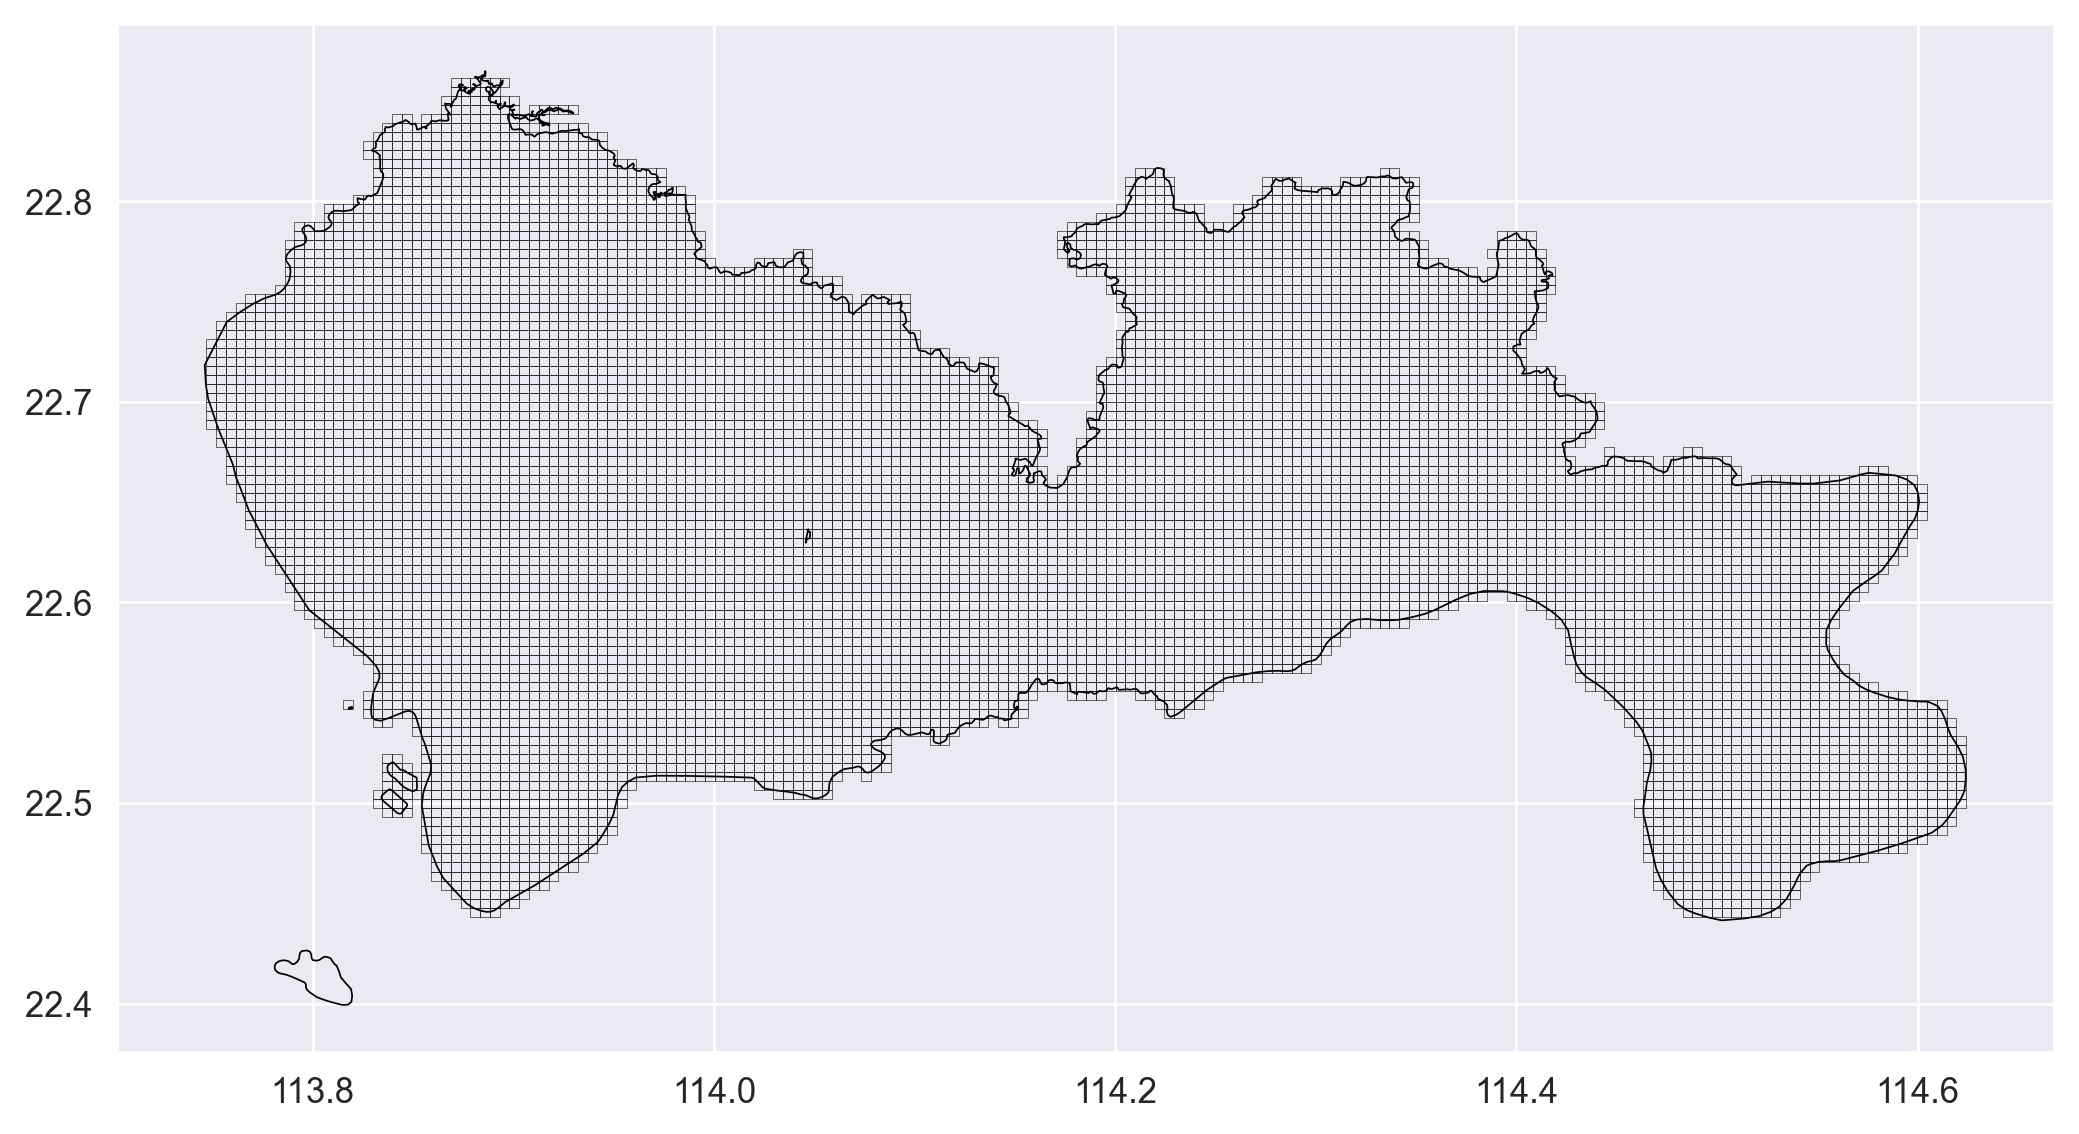

In [18]:
# 集计栅格OD（全天、高峰时段）
# VehicleNum变量在这里groupby，此字段就变成了计数count数量，不再是车牌号了
OD = (
    TaxiOD.groupby(["SLONCOL", "SLATCOL", "ELONCOL", "ELATCOL"])["VehicleNum"]
    .count()
    .reset_index()
)
# OD按照大小排列
OD = OD.sort_values(by="VehicleNum", ascending=False)


# 绘制栅格的OD矩阵图

# 绘制取前20个的OD
Topod = OD.iloc[:20].copy()

# 计算起点栅格的中心点经纬度
Topod["SHBLON"] = Topod["SLONCOL"] * deltaLon + (lonStart - deltaLon / 2)
Topod["SHBLAT"] = Topod["SLATCOL"] * deltaLat + (latStart - deltaLat / 2)

# 计算终点栅格的中心点经纬度
Topod["EHBLON"] = Topod["ELONCOL"] * deltaLon + (lonStart - deltaLon / 2)
Topod["EHBLAT"] = Topod["ELATCOL"] * deltaLat + (latStart - deltaLat / 2)

# 绘图包调用
fig = plt.figure(1, (10, 8), dpi=250)
ax = plt.subplot(111)
plt.sca(ax)

# 把刚才生成的栅格在ax上绘制
grid.plot(ax=ax, edgecolor=(0, 0, 0, 0.8), facecolor=(0, 0, 0, 0), linewidths=0.2)

# 把合并的行政区划变成一个geopandas，在ax上绘制
SZ_all = geopandas.GeoDataFrame()
SZ_all["geometry"] = [sz.unary_union]
SZ_all.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0), linewidths=0.5)

plt.show()
fig.savefig("./images/SZ.png")


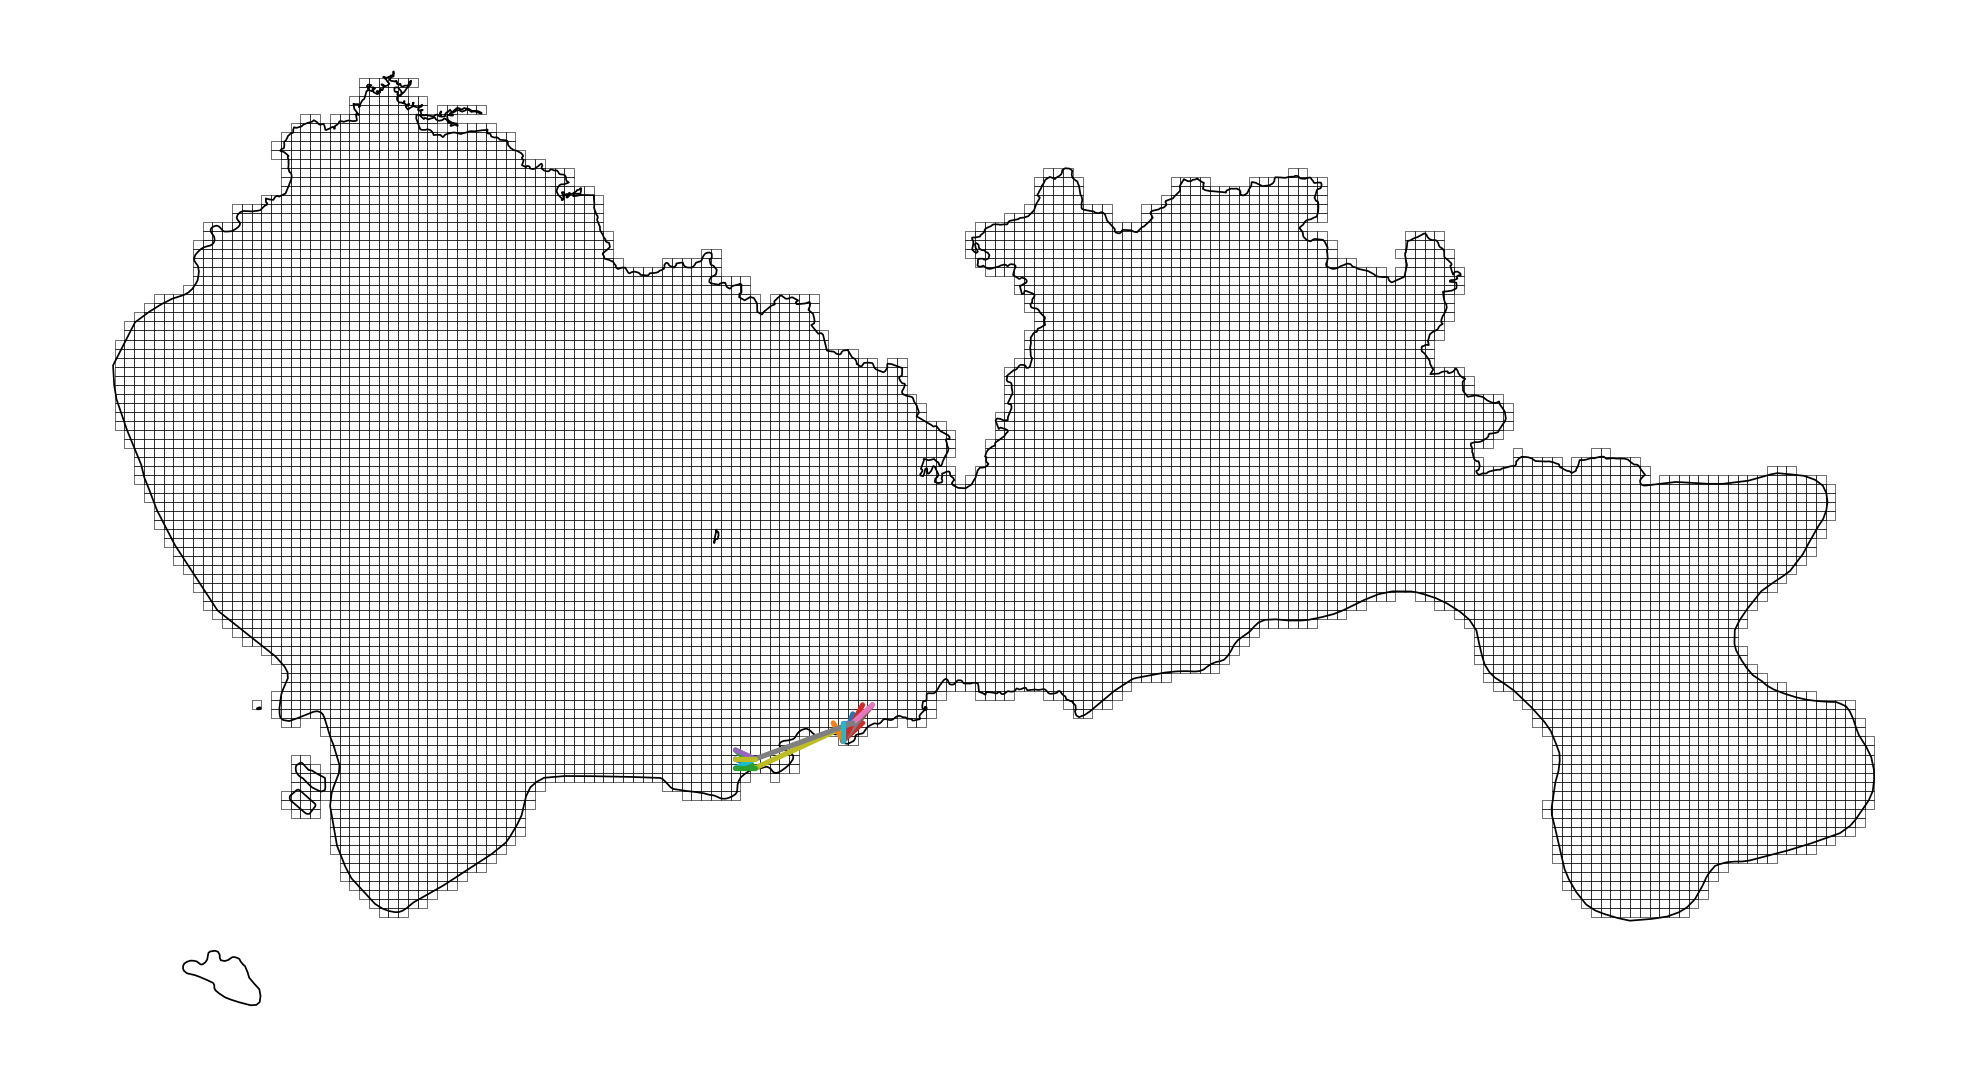

d:\Anaconda3\envs\paddle_env\lib\site-packages\pandas\core\dtypes\cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


绘制底图用时 2.2415108680725098 秒
绘制OD用时 0.38407135009765625 秒


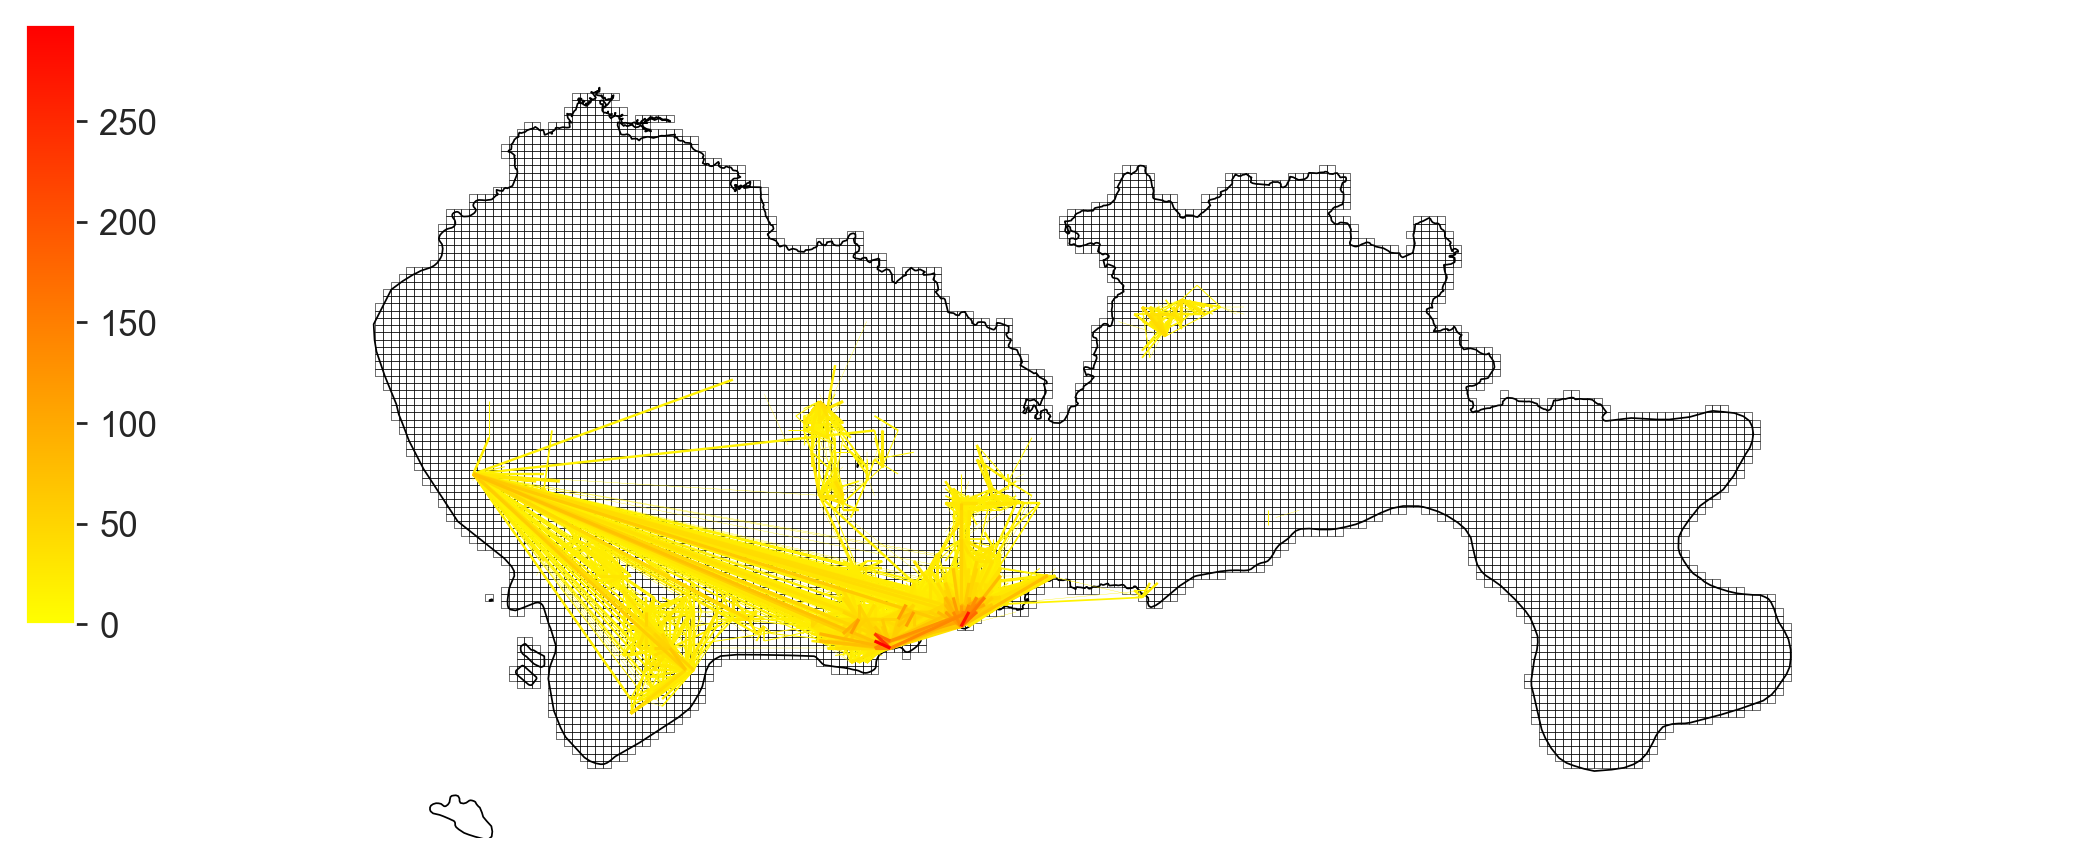

In [19]:
# 绘制OD
fig = plt.figure(1, (10, 8), dpi=250)
ax = plt.subplot(111)
plt.sca(ax)

grid.plot(ax=ax, edgecolor=(0, 0, 0, 0.8), facecolor=(0, 0, 0, 0), linewidths=0.2)
SZ_all.plot(ax=ax, edgecolor=(0, 0, 0, 1), facecolor=(0, 0, 0, 0), linewidths=0.5)

for i in range(len(Topod)):
    plt.plot(
        [Topod["SHBLON"].iloc[i], Topod["EHBLON"].iloc[i]],
        [Topod["SHBLAT"].iloc[i], Topod["EHBLAT"].iloc[i]],
    )

# 不显示坐标轴
plt.axis("off")
plt.show()
fig.savefig("./images/Top20OD.png")


# 绘制全部的OD
# 用OD的粗细，颜色深度，和透明度，来表示OD量大小
OD1 = OD[OD["VehicleNum"] > 10].copy()

# OD从小到大排序方便我们后续操作，因为我们希望小的OD先画，放在最底下，大的OD后画，放在最上面
OD1 = OD1.sort_values(by="VehicleNum")

# 计算起点栅格的中心点经纬度
OD1["SHBLON"] = OD1["SLONCOL"] * deltaLon + (lonStart - deltaLon / 2)
OD1["SHBLAT"] = OD1["SLATCOL"] * deltaLat + (latStart - deltaLat / 2)

# 计算终点栅格的中心点经纬度
OD1["EHBLON"] = OD1["ELONCOL"] * deltaLon + (lonStart - deltaLon / 2)
OD1["EHBLAT"] = OD1["ELATCOL"] * deltaLat + (latStart - deltaLat / 2)

# 对OD分5组，生成一个取值为0-1的列，每组的值相同，用以表示OD的粗细，取名linewidth
step = 5
OD1["linewidth"] = (np.array(range(len(OD1))) * step / len(OD1)).astype(
    "int"
) / step + 0.1

# 绘制
# 如果遍历绘制OD，绘制速度比较慢，绘制5319条OD用时31s。  
# 但是，如果把DataFrame变成GeoDataFrame，然后用自带的plot函数绘制，会快很多
from shapely.geometry import LineString
OD1['geometry'] = OD1.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
OD1 = geopandas.GeoDataFrame(OD1)

fig = plt.figure(1,(10,8),dpi = 250)    
ax = plt.subplot(111)
plt.sca(ax)

#计时
import time
timeflag = time.time()
#绘制底图
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print('绘制底图用时',time.time()-timeflag,'秒')


#设置colormap的数据
import matplotlib
vmax = OD['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

timeflag = time.time()
#绘制OD
OD1.plot(ax = ax,column = 'VehicleNum',vmax = vmax,vmin = 0,cmap = cmap,linewidth = OD1['linewidth'])
print('绘制OD用时',time.time()-timeflag,'秒')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()
fig.savefig('./images/ODDraw.png',dpi = 250)

### 三、将OD数据集计到行政区划，并绘制OD期望线
使用数据：深圳行政区划 深圳栅格 出租车GPS集计栅格OD

<AxesSubplot: >

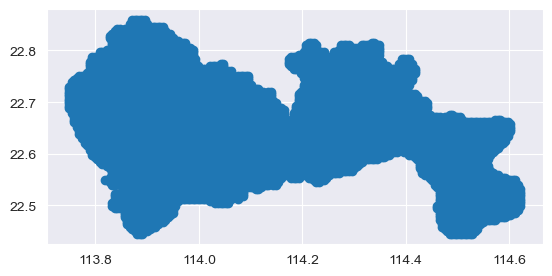

In [20]:
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8') # 文件为之前的shapefile\sz.shp

# 栅格数据
# 读取shapefile文件
shp = r'shapefile\grid\grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

# OD数据
OD = pd.read_csv(r'data-sample\taxi_od_grid.csv')

# 栅格与小区、行政区的匹配
# 定义一个geoDataFrame变量，命名为grid_point，存储的是栅格的中心点
grid_point = grid.copy()
#我们相当于把geometry这一列的信息由polygon改成point
grid_point['geometry'] = grid.centroid
# 绘制查看
grid_point.plot()


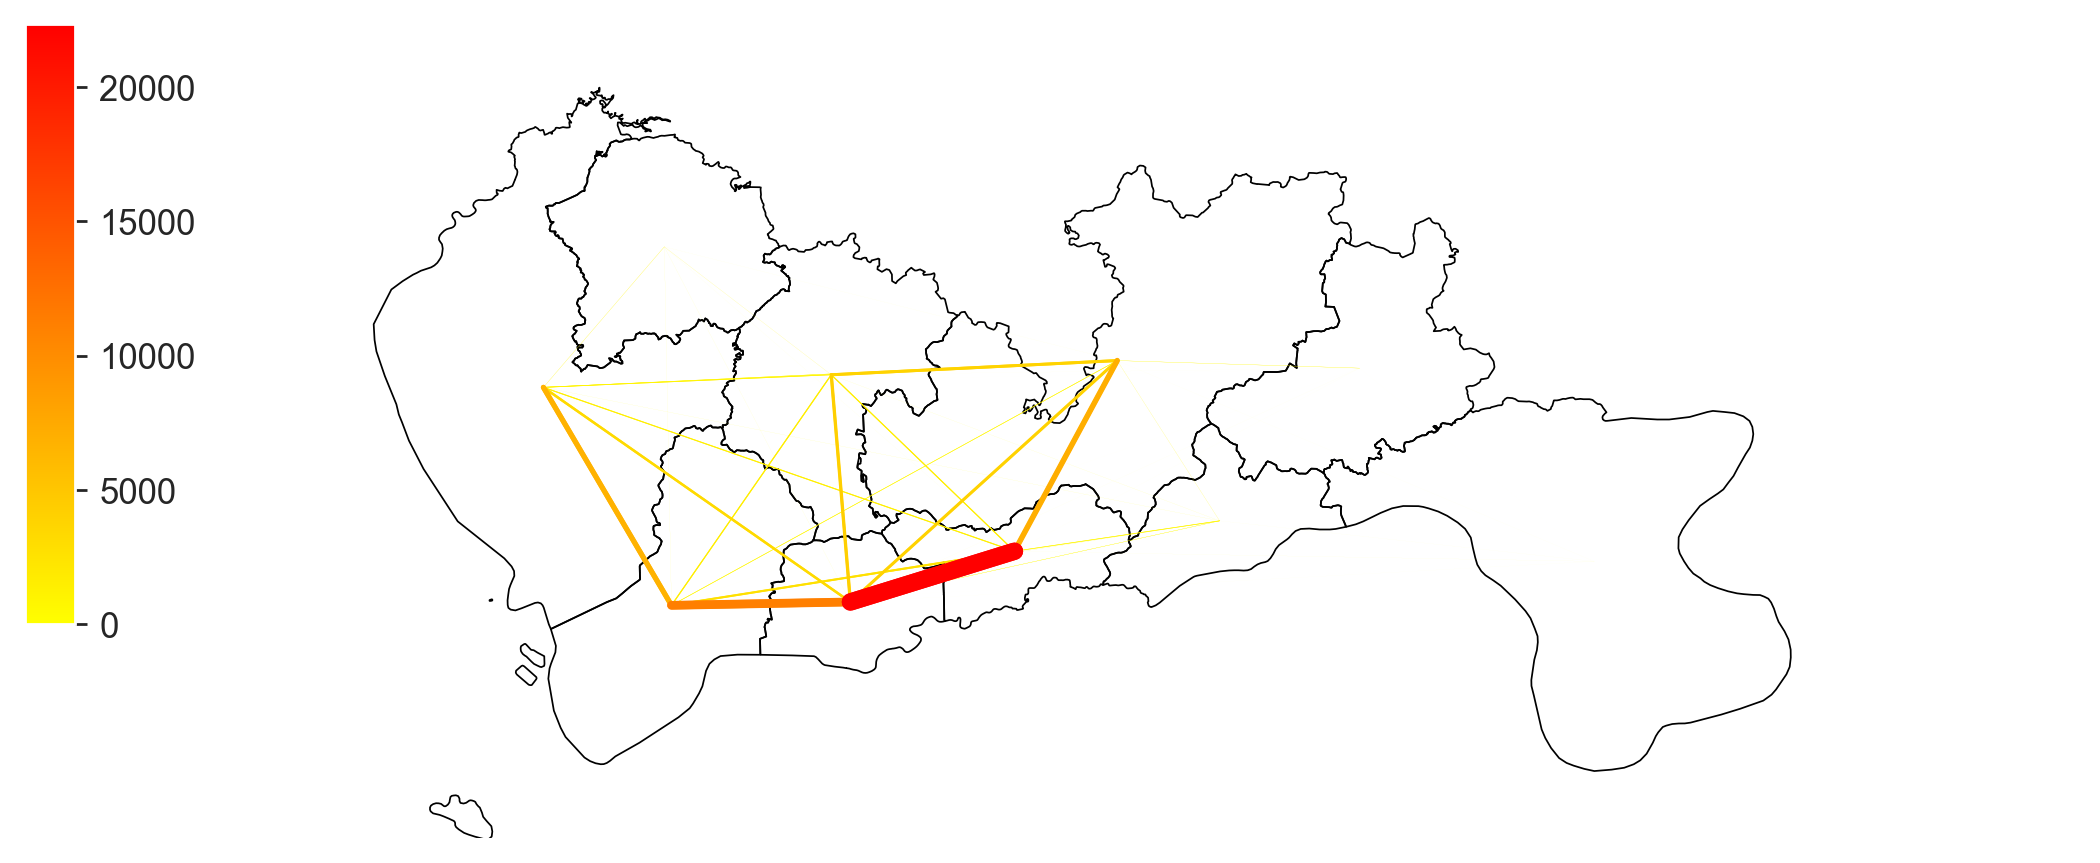

In [21]:
# 空间连接sjoin 连接到行政区划
grid_point = geopandas.sjoin(grid_point, xzqh, how="inner", op='intersects')
# 只取我们要的列
grid_point = grid_point[['LONCOL','LATCOL','qh','centroid_x','centroid_y']]

# 把OD表的起点终点和grid_point表连接
grid_point.columns = ['SLONCOL','SLATCOL','Sqh','S_x','S_y']
OD = pd.merge(OD,grid_point,on = ['SLONCOL','SLATCOL'])
grid_point.columns = ['ELONCOL','ELATCOL','Eqh','E_x','E_y']
OD = pd.merge(OD,grid_point,on = ['ELONCOL','ELATCOL'])

# 集计
OD = OD.groupby(['Sqh','S_x','S_y','Eqh','E_x','E_y'])['VehicleNum'].sum().reset_index()
OD = OD[-(OD['Sqh']==OD['Eqh'])] #去除起点终点相同的OD，跨区

# 画图
OD = OD.sort_values(by = 'VehicleNum')

# 导入绘图包
fig = plt.figure(1,(10,8),dpi = 250)    
ax = plt.subplot(111)
plt.sca(ax)

# 绘制行政区划
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

# 设置colormap的数据
vmax = OD['VehicleNum'].max()
# 设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
# 设定colormap的颜色
cmapname = 'autumn_r'
# cmap是一个获取颜色的工具，cmap(a)会返回颜色，其中a是0-1之间的值
cmap = matplotlib.cm.get_cmap(cmapname)

# 绘制OD
for i in range(len(OD)):
    # 设定第i条线的color和linewidth
    color_i=cmap(norm(OD['VehicleNum'].iloc[i]))
    linewidth_i=norm(OD['VehicleNum'].iloc[i])*5
    # 绘制
    plt.plot([OD['S_x'].iloc[i],OD['E_x'].iloc[i]],[OD['S_y'].iloc[i],OD['E_y'].iloc[i]],color=color_i,linewidth=linewidth_i)

# 不显示坐标轴
plt.axis('off')    

# 绘制假的colorbar，这是因为，我们画的OD是线，没办法直接画出来colorbar
# 所以我们在一个看不见的地方画了一个叫imshow的东西，他的范围是0到vmax
# 然后我们再对imshow添加colorbar
plt.imshow([[0,vmax]], cmap=cmap)
# 设定colorbar的大小和位置
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

# 然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()
fig.savefig('./images/4-ODSZ.png')


### 四、绘制数据的分布情况：即散点图和热力图
需要：出租车原始GPS数据(在data-sample文件夹下，原始数据集的抽样500辆车的数据)

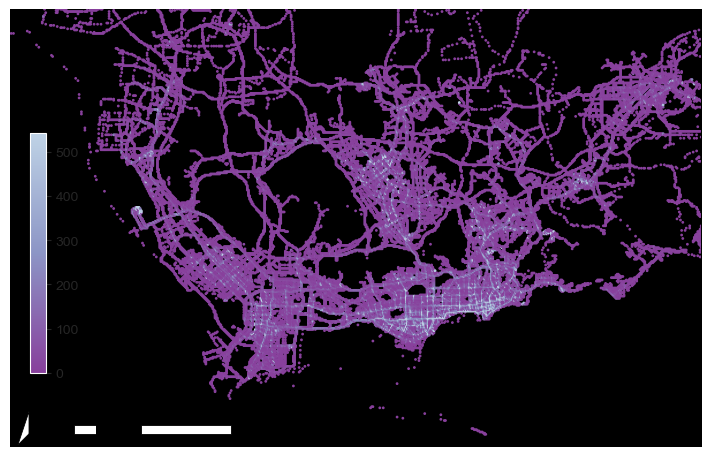

In [23]:
# plot_map.py为开源的绘制深圳地图的包，这里底图较难绘制，可用folium包绘制
import plot_map

# 读取数据
data = pd.read_csv(r'data-sample\TaxiData-Sample',header = None)
# 给数据命名列
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']

# 筛选范围内数据
bounds = [113.7, 22.42, 114.3, 22.8]
data = data[(data['Lng']>bounds[0])&(data['Lng']<bounds[2])&(data['Lat']>bounds[1])&(data['Lat']<bounds[3])]

# 经纬度小数点保留三位小数
data2 = data[['Lng','Lat']].round(3).copy()

# 集计每个小范围内数据量
data2['count'] = 1
data2 = data2.groupby(['Lng','Lat'])['count'].count().reset_index()

# 排序数据，让数据量小的放上面先画，数据大的放下面最后画
data2.sort_values(by = 'count')

# 散点图绘制
bounds = [113.7, 22.42, 114.3, 22.8]
fig = plt.figure(1,(8,8),dpi = 100)    
ax = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

#背景
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

# colorbar
pallete_name = "BuPu"
colors = sns.color_palette(pallete_name, 3)
colors.reverse()
cmap = mpl.colors.LinearSegmentedColormap.from_list(pallete_name, colors)
vmax = data2['count'].quantile(0.99)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)

# plot scatters
plt.scatter(data2['Lng'],data2['Lat'],s = 1,alpha = 1,c = data2['count'],cmap = cmap,norm=norm )
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

# 加比例尺和指北针
plot_map.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,accuracy = 2000,rect = [0.06,0.03])

# 假colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.33, 0.02, 0.3])
plt.colorbar(cax=cax)

plt.show()
fig.savefig('./images/scatter.png')


C:\Users\14684\AppData\Local\Temp\ipykernel_12816\3137167374.py:3: RuntimeWarning: divide by zero encountered in log
  z = np.log(d.values)


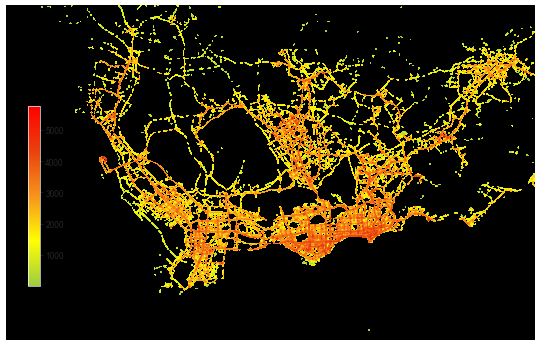

In [24]:
# 热力图绘制(使用contourf)
d = data2.pivot(columns = 'Lng',index = 'Lat',values = 'count').fillna(0)
z = np.log(d.values)
x = d.columns
y = d.index

levels = np.linspace(0, z.max(), 25)
bounds = [113.7, 22.42, 114.3, 22.8]

#   -- plot --
fig = plt.figure(1,(10,10),dpi = 60)  
ax = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))#调整整体空白

# 绘制底图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

# colorbar的数据
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)

# 绘制热力图
plt.contourf(x,y,z, levels=levels, cmap=cmap,origin = 'lower')
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

# 绘制假的colorbar
plt.imshow([np.exp(levels)], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

plt.show()
fig.savefig('./images/heatmap1.png')

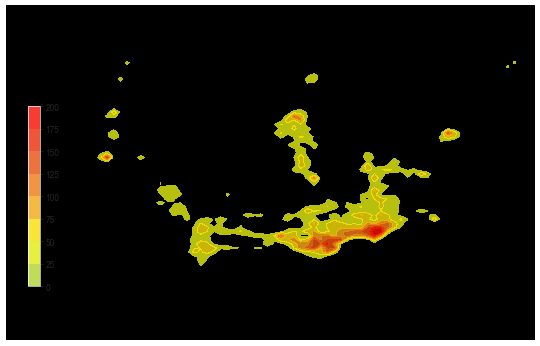

In [25]:
# 热力图绘制（scipy，还可采用seaborn-kdeplot）
import scipy
scipy.__version__
def heatmapplot(data,weight,gridsize = 100,bw = 'scott',cmap = plt.cm.gist_earth_r, ax=None,**kwargs):
    #数据整理
    from scipy import stats
    m1 = data[:,0]
    m2 = data[:,1]
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()
    X, Y = np.mgrid[xmin:xmax:(xmax-xmin)/gridsize, ymin:ymax:(ymax-ymin)/gridsize]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    #用scipy计算带权重的高斯kde
    kernel = stats.gaussian_kde(values,bw_method = bw,weights = weight)
    Z = np.reshape(kernel(positions).T, X.shape)
    #绘制contourf
    cset = ax.contourf(Z.T,extent=[xmin, xmax, ymin, ymax],cmap = cmap,**kwargs)
    #设置最底层为透明
    cset.collections[0].set_alpha(0)
    
    return cset

bounds = [113.7, 22.42, 114.3, 22.8]

#   -- plot --
fig = plt.figure(1,(10,10),dpi = 60)    
ax = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))#调整整体空白

#绘制底图
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#colorbar的数据
import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)

#设定位置
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])

#绘制热力图
cset = heatmapplot(data2.values,  #输入经纬度数据
            data2['count'],       #输入每个点的权重
            alpha = 0.8,          #透明度
            gridsize = 80,        #绘图精细度，越高越慢
            bw = 0.03,            #高斯核大小（经纬度），越小越精细
            cmap = cmap,
            ax = ax
           )

#定义colorbar位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cset,cax=cax)

plt.show()
fig.savefig('./images/heatmap2.png')

以上，就完成了基本的数据预处理和基本的数据可视化分析，为后续的数据分析做好了准备。  
后续分析：taxi-analysis.ipynb